# Comparsion of optimizers

In [1]:
import random
import numpy as np
import time
from qiskit import QuantumCircuit, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import SPSA, COBYLA, ADAM

### Generate a random state as the target

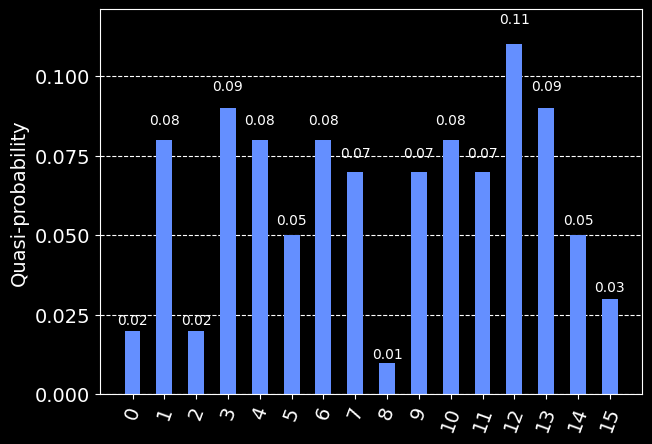

In [2]:
random.seed(102)
distr = [random.random() for i in range(16)]
target_distr = {i: round(distr[i] / sum(distr), 2) for i in range(16)}
plot_histogram(target_distr)

### Define the ansatz and others

In [3]:
def ansatz(params, n_qubits=4, rep=2):
    """
        params are the trainable parameters
        n_qubits is the number of qubits in the ansatz
        rep is the repetation of the controlled-RY group
    """
    if len(params) != n_qubits + rep*(2*n_qubits-1):
        raise Exception("the number of parameters doesn't match")
    
    # build the circuit
    qc = QuantumCircuit(n_qubits)
    qc.x(0)
    qc.h(range(1, n_qubits))
    for n in range(n_qubits):
        qc.ry(params[n], n)
    for i in range(rep):
        for n in range(n_qubits-1):
            qc.cry(params[n_qubits+(2*n_qubits-1)*i+n], n, n+1)
            qc.ry(params[n_qubits+(2*n_qubits-1)*i+n+n_qubits-1], n)
        qc.ry(params[n_qubits+(2*n_qubits-1)*i+(2*n_qubits-2)], n_qubits-1)
    #display(qc.draw('mpl'))
    return qc

In [4]:
init_params = np.ones(18)

In [5]:
## define a function to convert the statevector to distribution
def sv_to_distr(sv):
    sv_dict = sv.to_dict()
    sv_dict = {key: np.abs(value)**2 for key, value in sv_dict.items()}
    cumulant = sum(sv_dict.values())
    sv_dict = {int(key, 2): value/cumulant for key, value in sv_dict.items()}
    return sv_dict

## define the cost function
def cost_func(params, trace=False):
    qc = ansatz(params)
    output_distr = sv_to_distr(Statevector(qc))
    cost = sum(
        abs(target_distr.get(key, 0) - output_distr.get(key, 0))**2
        for key, value in output_distr.items()
    )
    return cost

### COBYLA

In [8]:
optimizer = COBYLA(maxiter=1e5)

start = time.time()

# optimization
result = optimizer.minimize(
    fun=cost_func,
    x0=init_params)

stop = time.time()
print("time consumed:", round(stop-start, 2), "s")

time consumed: 75.37 s


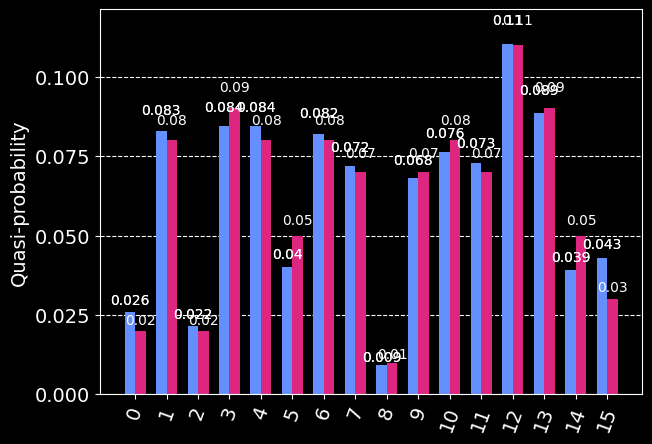

In [7]:
qc = ansatz(result.x)
output_distr = sv_to_distr(Statevector(qc))
plot_histogram([output_distr, target_distr])